## Stock Market Trading Strategy
#### Objective
This project implements a **Long Short-Term Memory (LSTM)** neural network model to predict stock prices based historical market data.  
The model leverages sequential learning to capture temporal dependencies in price movements, enabling more accurate forecasting for investment and trading decision-making.

#### Import Libraries

In [23]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping


#### Load Data

In [45]:
# Loading the New Training and Validation Datasets
training_data = pd.read_csv('/content/IVV_1m_validation.csv').head(500000)
validation_data = pd.read_csv('/content/IVV_1m_validation.csv').head(500000)

# Use of 'Close' column for prediction
df1_train = training_data['Close']
df1_val = validation_data['Close']


#### Data Summary and Plotting

Training Data Summary:
                 Low        Volume           Open           High  \
count  292620.000000  2.926200e+05  292620.000000  292620.000000   
mean      271.796520  9.052812e+03     271.838533     271.879637   
std        22.745787  2.247355e+04      22.748624      22.751417   
min       225.240000  1.000000e+02     225.291700     225.350000   
25%       251.784625  2.378000e+03     251.809975     251.824725   
50%       274.207650  4.514000e+03     274.260000     274.305150   
75%       289.420000  8.908000e+03     289.470000     289.520000   
max       324.990000  2.789013e+06     325.190000     325.190000   

               Close  
count  292620.000000  
mean      271.837685  
std        22.748545  
min       225.300000  
25%       251.808350  
50%       274.250000  
75%       289.471325  
max       325.060000  

Validation Data Summary:
                 Low        Volume           Open           High  \
count  292620.000000  2.926200e+05  292620.000000  292620.00000

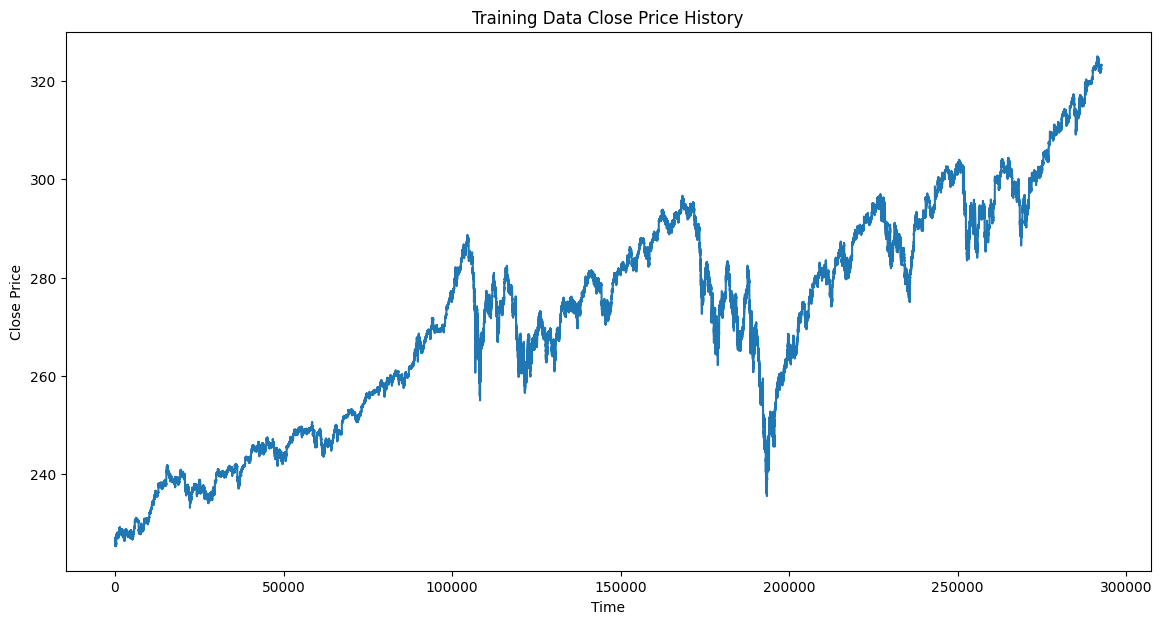

In [46]:
# Data Summary
print("Training Data Summary:")
print(training_data.describe())
print("\nValidation Data Summary:")
print(validation_data.describe())

# Plot Training Data
plt.figure(figsize=(14, 7))
plt.plot(df1_train)
plt.title('Training Data Close Price History')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.show()


#### Scale Data

In [47]:
# Scaling Data
scaler = MinMaxScaler(feature_range=(0, 1))
df1_train = scaler.fit_transform(np.array(df1_train).reshape(-1, 1))
df1_val = scaler.transform(np.array(df1_val).reshape(-1, 1))


#### Creating Dataset for LSTM

In [48]:
# Create Dataset for LSTM
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Define the time step
time_step = 100
X_train, y_train = create_dataset(df1_train, time_step)
X_val, y_val = create_dataset(df1_val, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)


#### Creatig and Compiling LSTM Model


In [49]:
# Creating and Compiling LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1), kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    LSTM(50, return_sequences=True, kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    LSTM(50, kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(1, kernel_regularizer=l2(0.01))
])
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 dropout_3 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 dropout_4 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

#### Training the Model

In [50]:
# Adding early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the Model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=64, verbose=1, callbacks=[early_stop])


Epoch 1/100
4571/4571 [==============================] - 104s 22ms/step - loss: 0.0225 - val_loss: 8.1943e-04
Epoch 2/100
4571/4571 [==============================] - 94s 21ms/step - loss: 0.0011 - val_loss: 7.9673e-04
Epoch 3/100
4571/4571 [==============================] - 95s 21ms/step - loss: 9.3319e-04 - val_loss: 5.4526e-04
Epoch 4/100
4571/4571 [==============================] - 94s 20ms/step - loss: 8.7892e-04 - val_loss: 6.6711e-04
Epoch 5/100
4571/4571 [==============================] - 95s 21ms/step - loss: 8.1787e-04 - val_loss: 4.2453e-04
Epoch 6/100
4571/4571 [==============================] - 94s 21ms/step - loss: 7.9275e-04 - val_loss: 4.2333e-04
Epoch 7/100
4571/4571 [==============================] - 94s 21ms/step - loss: 7.4804e-04 - val_loss: 5.4112e-04
Epoch 8/100
4571/4571 [==============================] - 94s 21ms/step - loss: 7.0315e-04 - val_loss: 4.9197e-04
Epoch 9/100
4571/4571 [==============================] - 94s 21ms/step - loss: 7.1012e-04 - val_loss: 4

#### Prediction and Evaluation

In [51]:
# Prediction and Evaluation on Training and Validation Data
train_predict = model.predict(X_train)
val_predict = model.predict(X_val)

# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
val_predict = scaler.inverse_transform(val_predict)

# Calculate RMSE performance metrics
train_rmse = math.sqrt(mean_squared_error(scaler.inverse_transform(y_train.reshape(-1, 1)), train_predict))
val_rmse = math.sqrt(mean_squared_error(scaler.inverse_transform(y_val.reshape(-1, 1)), val_predict))

print(f'Train Data RMSE: {train_rmse}')
print(f'Validation Data RMSE: {val_rmse}')


9142/9142 [==============================] - 57s 6ms/step
Train Data RMSE: 0.9727804440236854
Validation Data RMSE: 0.9727804440236854


#### Visualization of Results

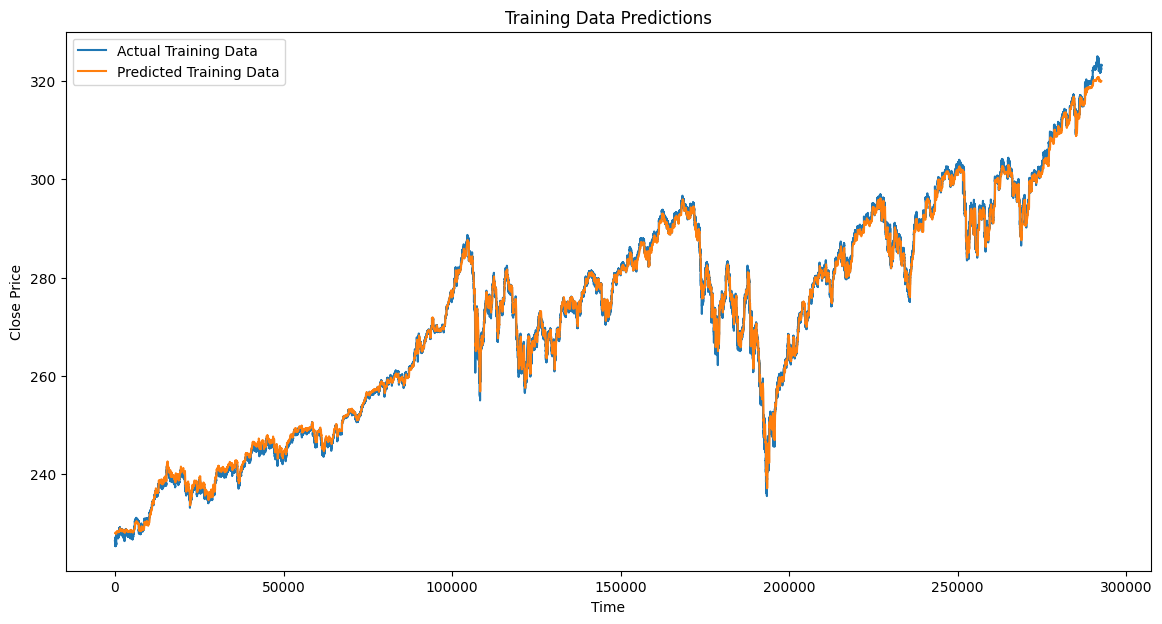

In [52]:

# Plot training predictions
plt.figure(figsize=(14, 7))
plt.plot(scaler.inverse_transform(df1_train), label='Actual Training Data')
plt.plot(np.arange(time_step, time_step + len(train_predict)), train_predict, label='Predicted Training Data')
plt.title('Training Data Predictions')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()




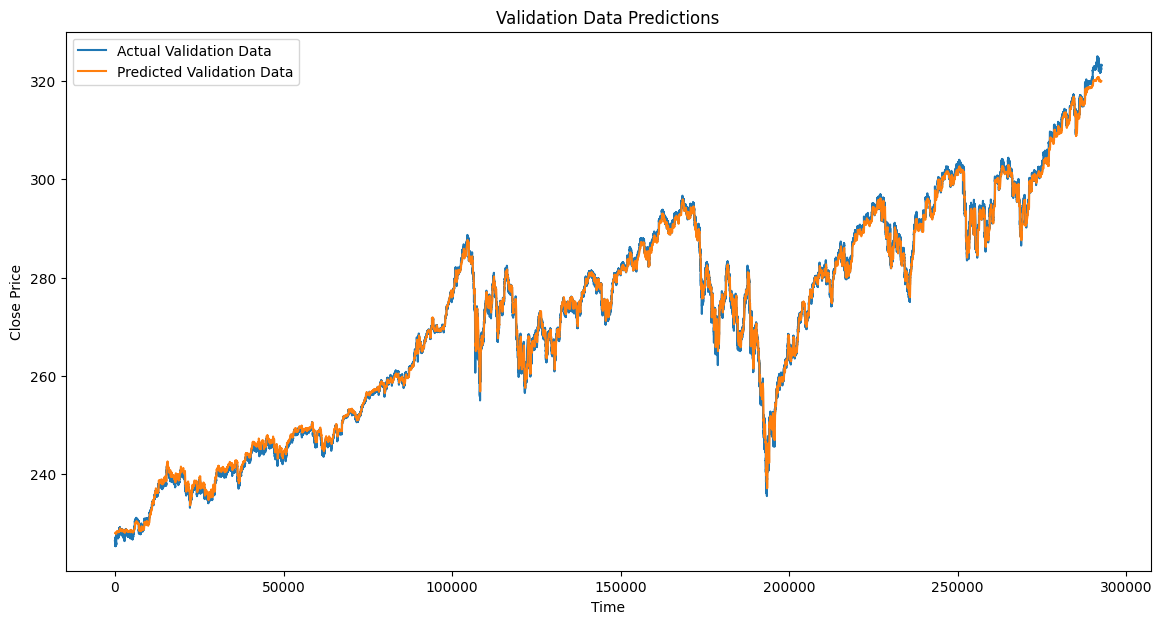

In [53]:
# Plot validation predictions
plt.figure(figsize=(14, 7))
plt.plot(scaler.inverse_transform(df1_val), label='Actual Validation Data')
plt.plot(np.arange(time_step, time_step + len(val_predict)), val_predict, label='Predicted Validation Data')
plt.title('Validation Data Predictions')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

#### Save the Model

In [54]:
# Save the model for future testing
model.save('lstm_stock_model.h5')
print("Model saved as lstm_stock_model.h5")


Model saved as lstm_stock_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Load and Prepare Test Data

In [55]:
#### Import Libraries
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math



Test Data Summary:
                 Low        Volume           Open           High  \
count  387750.000000  3.876090e+05  387750.000000  387750.000000   
mean      396.628135  1.155466e+04     396.728746     396.828296   
std        52.227122  2.690450e+04      52.212459      52.196515   
min       220.275600  1.860000e+02     220.480000     220.680000   
25%       368.100000  3.854000e+03     368.210000     368.307450   
50%       407.940000  6.721000e+03     408.020000     408.108450   
75%       438.240000  1.227800e+04     438.340000     438.430000   
max       481.790000  2.710650e+06     481.950000     482.070000   

               Close  
count  387750.000000  
mean      396.728114  
std        52.212424  
min       220.405000  
25%       368.201250  
50%       408.020000  
75%       438.340000  
max       481.940000  


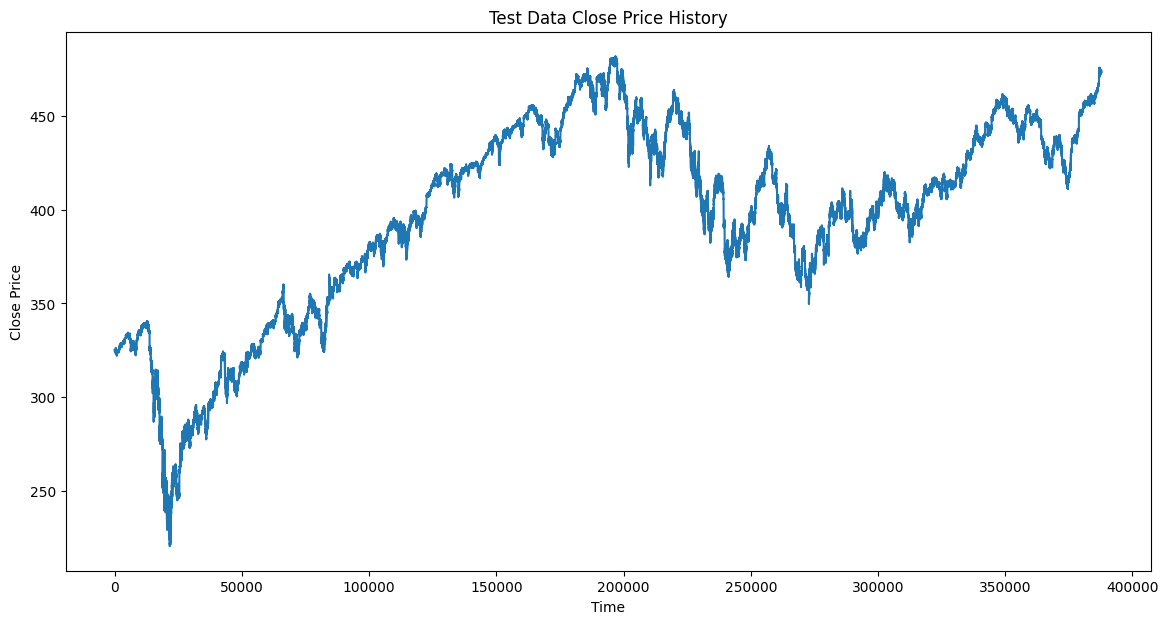

In [56]:
#### Load the Test Data
test_data = pd.read_csv('/content/IVV_test_sample.csv')

# Use of 'Close' column for prediction
df1_test = test_data['Close']

# Data Summary
print("Test Data Summary:")
print(test_data.describe())

# Plot Test Data
plt.figure(figsize=(14, 7))
plt.plot(df1_test)
plt.title('Test Data Close Price History')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.show()



In [57]:
#### Scale Data
# Note: Use the same scaler fitted on the training data
df1_test = scaler.transform(np.array(df1_test).reshape(-1, 1))



In [58]:
#### Creating Dataset for LSTM
# Define the same create_dataset function and time_step as used before
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)



In [59]:
# Create the test dataset
X_test, y_test = create_dataset(df1_test, time_step)


In [60]:

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)



In [61]:
#### Load the Saved Model
model = keras.models.load_model('lstm_stock_model.h5')



In [62]:
#### Prediction and Evaluation
# Make predictions on test data
test_predict = model.predict(X_test)



12115/12115 [==============================] - 77s 6ms/step


In [63]:
# Transform back to original form
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE performance metrics
test_rmse = math.sqrt(mean_squared_error(y_test, test_predict))
print(f'Test Data RMSE: {test_rmse}')



Test Data RMSE: 89.24470161078844


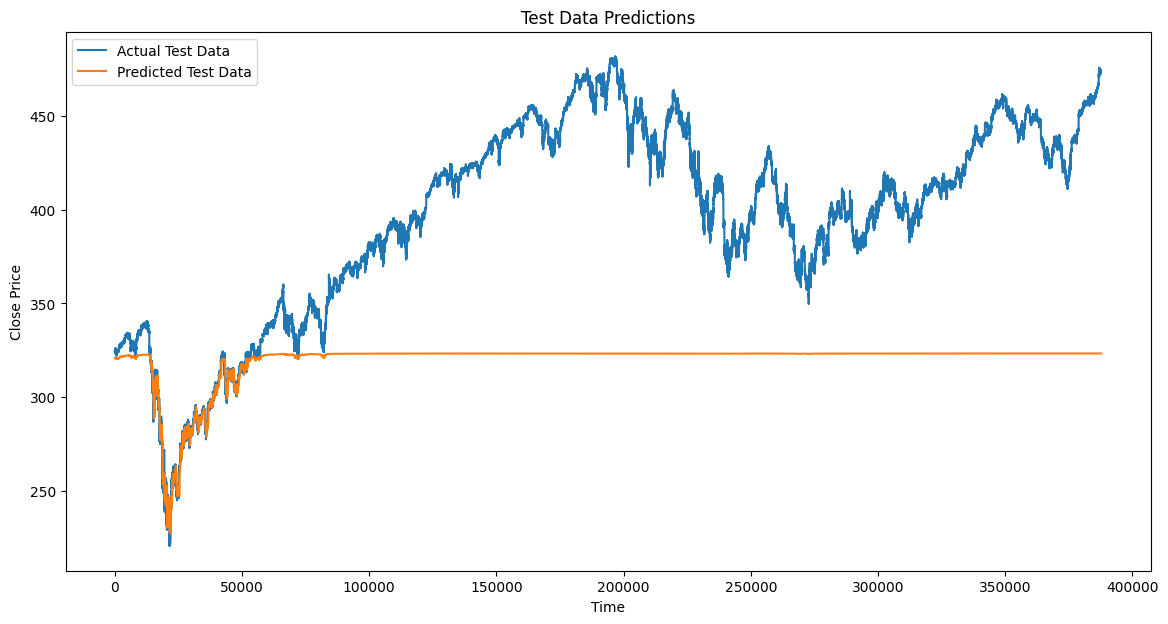

In [64]:
#### Visualization of Results
# Plot test predictions
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual Test Data')
plt.plot(np.arange(time_step, time_step + len(test_predict)), test_predict, label='Predicted Test Data')
plt.title('Test Data Predictions')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()


#### Implement Investment Strategy

In [73]:
initial_wealth = 1000
wealth = initial_wealth
wealth_process = [initial_wealth]  # Initialize with the starting wealth

predicted_growth_correct = 0
total_predictions = len(test_predict)

for i in range(1, total_predictions):
    if test_predict[i] > test_predict[i-1]:
        # Extract the numerical values from the arrays before performing the calculation
        wealth *= (y_test[i][0] / y_test[i-1][0])
    else:
        # Stay in cash, no change in wealth
        wealth = wealth
    wealth_process.append(wealth)  # Ensure wealth is appended regardless of condition


    if (test_predict[i] > test_predict[i-1]) and (y_test[i] > y_test[i-1]):
        predicted_growth_correct += 1

# Calculating the percentage of correct growth predictions
correct_growth_percentage = (predicted_growth_correct / (total_predictions - 1)) * 100
print(f'Correct Growth Predictions: {correct_growth_percentage:.2f}%')

Correct Growth Predictions: 16.89%


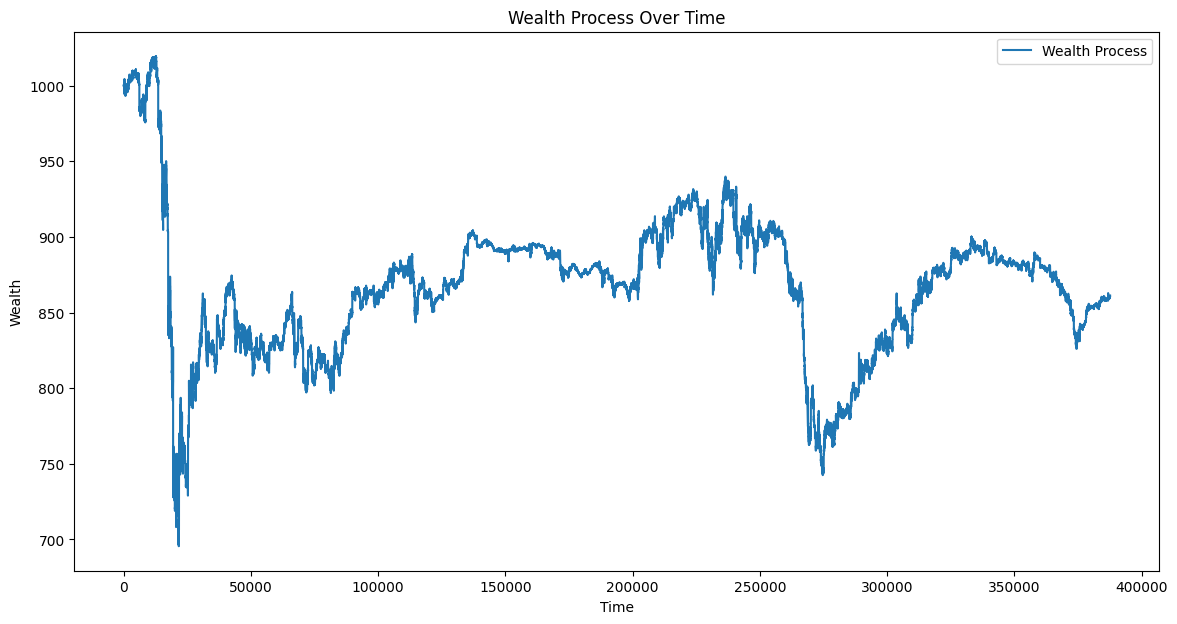

In [74]:
# Plot Wealth Process
plt.figure(figsize=(14, 7))
plt.plot(range(len(wealth_process)), wealth_process, label='Wealth Process')
plt.title('Wealth Process Over Time')
plt.xlabel('Time')
plt.ylabel('Wealth')
plt.legend()
plt.show()